In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/My Drive/Github/"CS 499 - SPRING 2022"/"3. Experiments"/"2. STAN-Without Missing Data"
! pip install epiweeks
! pip install haversine
! pip install dgl

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Github/CS 499 - SPRING 2022/3. Experiments/2. STAN-Without Missing Data


In [ ]:
"""
Import libraries needed
"""
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocess_data_library import get_preprocessed_data
from model import STAN
from torch import nn

In [ ]:
# Get preprocessed data and unpackage variables needed during training/testing/validation

preprocessed_data = get_preprocessed_data()

training_variables = preprocessed_data['training_variables']
validation_variables = preprocessed_data['validation_variables']
testing_variables = preprocessed_data['testing_variables']
normalization_variables = preprocessed_data['normalization_variables']

static_feat = preprocessed_data['static_feat']
loc_list = preprocessed_data['loc_list']
g = preprocessed_data['graph']
active_cases = preprocessed_data['active_cases'] # used only in graphing

train_x = training_variables['train_x']
train_I = training_variables['train_I']
train_R = training_variables['train_R']
train_cI = training_variables['train_cI']
train_cR = training_variables['train_cR']
train_yI = training_variables['train_yI']
train_yR = training_variables['train_yR']

val_x = validation_variables['val_x']
val_I = validation_variables['val_I']
val_R = validation_variables['val_R']
val_cI = validation_variables['val_cI']
val_cR = validation_variables['val_cR']
val_yI = validation_variables['val_yI']
val_yR = validation_variables['val_yR']

test_x = testing_variables['test_x']
test_I = testing_variables['test_I']
test_R = testing_variables['test_R']
test_cI = testing_variables['test_cI']
test_cR = testing_variables['test_cR']
test_yI = testing_variables['test_yI']
test_yR = testing_variables['test_yR']

dI_mean = normalization_variables['dI_mean']
dI_std = normalization_variables['dI_std']
dR_mean = normalization_variables['dR_mean']
dR_std = normalization_variables['dR_std']

Finish download


In [ ]:
history_window = 6 # Redeclared from preprocess_data_library
pred_window = 15 # Redeclared from preprocess_data_library
slide_step = 5 # Redeclared from preprocess_data_library

#Build STAN model

in_dim = 3*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [ ]:
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=18, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_res_I): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_R): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_sir): Linear(in_features=34, out_features=2, bias=True)
)

In [ ]:
train_x = torch.tensor(train_x).to(device)
train_I = torch.tensor(train_I).to(device)
train_R = torch.tensor(train_R).to(device)
train_cI = torch.tensor(train_cI).to(device)
train_cR = torch.tensor(train_cR).to(device)
train_yI = torch.tensor(train_yI).to(device)
train_yR = torch.tensor(train_yR).to(device)

val_x = torch.tensor(val_x).to(device)
val_I = torch.tensor(val_I).to(device)
val_R = torch.tensor(val_R).to(device)
val_cI = torch.tensor(val_cI).to(device)
val_cR = torch.tensor(val_cR).to(device)
val_yI = torch.tensor(val_yI).to(device)
val_yR = torch.tensor(val_yR).to(device)

test_x = torch.tensor(test_x).to(device)
test_I = torch.tensor(test_I).to(device)
test_R = torch.tensor(test_R).to(device)
test_cI = torch.tensor(test_cI).to(device)
test_cR = torch.tensor(test_cR).to(device)
test_yI = torch.tensor(test_yI).to(device)
test_yR = torch.tensor(test_yR).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [ ]:
#Train STAN

all_loss = []
file_name = './save/stan'
min_loss = 1e10

loc_name = 'Kentucky'
cur_loc = loc_list.index(loc_name)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    
    active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
    loss = criterion(active_pred.squeeze(), train_yI[cur_loc])+criterion(recovered_pred.squeeze(), train_yR[cur_loc])+0.1*criterion(phy_active.squeeze(), train_yI[cur_loc])+0.1*criterion(phy_recover.squeeze(), train_yR[cur_loc])
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h)
    
    val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    val_loss = criterion(val_active_pred.squeeze(), val_yI[cur_loc]) + 0.1*criterion(val_phy_active.squeeze(), val_yI[cur_loc])
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss
        print('-----Save best model-----')
    
    print('Epoch %d, Loss %.2f, Val loss %.2f'%(epoch, all_loss[-1], val_loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


-----Save best model-----
Epoch 0, Loss 302.73, Val loss 58.80
Epoch 1, Loss 786.70, Val loss 291.71
Epoch 2, Loss 450.42, Val loss 141.48
-----Save best model-----
Epoch 3, Loss 91.12, Val loss 45.65
-----Save best model-----
Epoch 4, Loss 22.64, Val loss 18.11
-----Save best model-----
Epoch 5, Loss 9.03, Val loss 9.14
-----Save best model-----
Epoch 6, Loss 4.73, Val loss 5.67
-----Save best model-----
Epoch 7, Loss 3.12, Val loss 3.90
-----Save best model-----
Epoch 8, Loss 2.19, Val loss 2.97
-----Save best model-----
Epoch 9, Loss 1.63, Val loss 2.47
-----Save best model-----
Epoch 10, Loss 1.34, Val loss 1.94
-----Save best model-----
Epoch 11, Loss 1.19, Val loss 1.65
-----Save best model-----
Epoch 12, Loss 0.97, Val loss 1.54
-----Save best model-----
Epoch 13, Loss 0.90, Val loss 1.45
-----Save best model-----
Epoch 14, Loss 0.81, Val loss 1.40
-----Save best model-----
Epoch 15, Loss 0.75, Val loss 1.40
Epoch 16, Loss 0.72, Val loss 1.58
Epoch 17, Loss 0.67, Val loss 1.70
E

In [ ]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()


prev_x = torch.cat((train_x, val_x), dim=1)
prev_I = torch.cat((train_I, val_I), dim=1)
prev_R = torch.cat((train_R, val_R), dim=1)
prev_cI = torch.cat((train_cI, val_cI), dim=1)
prev_cR = torch.cat((train_cR, val_cR), dim=1)
prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc])


test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h)


In [ ]:
print('Estimated beta in SIR model is %.2f'%model.alpha_scaled)
print('Estimated gamma in SIR model is %.2f'%model.beta_scaled)

Estimated beta in SIR model is 0.04
Estimated gamma in SIR model is 0.01


In [ ]:
#Cumulate predicted dI
pred_I = []

for i in range(test_pred_active.size(1)):
    cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
    #cur_pred = test_pred_phy_active[0, i, :].detach().cpu().numpy()
    cur_pred = (cur_pred + test_pred_phy_active[0, i, :].detach().cpu().numpy()) / 2
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
    pred_I.append(cur_pred)
pred_I = np.array(pred_I)
pred_I = pred_I

In [ ]:
def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    
    y = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        y.append(data[:, i+history_window:i+history_window+pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

In [ ]:
I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

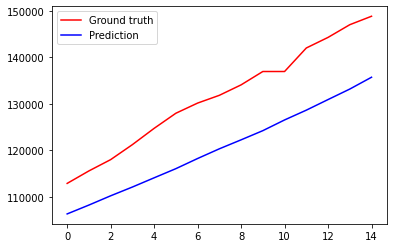

In [ ]:
plt.plot(I_true[cur_loc, -1, :],c='r', label='Ground truth')
plt.plot(pred_I[-1, :],c='b', label='Prediction')
plt.legend()
plt.show()